In [1]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import load_model

class ClothingExtractor:
    def __init__(self):
        # Load the human segmentation model
        self.segmentation_model = self._load_segmentation_model()
        # Load the clothing parsing model
        self.parsing_model = self._load_parsing_model()

    def _load_segmentation_model(self):
        # In a real implementation, we'd load a pre-trained model
        # Here using MobileNetV2 as an example backbone
        base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
        # Add segmentation head layers (simplified example)
        return tf.keras.Sequential([
            base_model,
            tf.keras.layers.Conv2DTranspose(64, 3, strides=2, padding='same', activation='relu'),
            tf.keras.layers.Conv2DTranspose(32, 3, strides=2, padding='same', activation='relu'),
            tf.keras.layers.Conv2D(1, 3, padding='same', activation='sigmoid')
        ])

    def _load_parsing_model(self):
        # In a real implementation, we'd load a specialized clothing parsing model
        # Such as a model trained on a dataset like ModaNet or DeepFashion
        return None  # Placeholder

    def extract_clothing(self, image):
        # Preprocess image
        img = cv2.resize(image, (224, 224))
        img = img / 255.0  # Normalize

        # Generate person mask
        person_mask = self.segmentation_model.predict(np.expand_dims(img, axis=0))[0]
        person_mask = cv2.resize(person_mask, (image.shape[1], image.shape[0]))

        # Apply mask to get the person
        person_segmented = image * np.expand_dims(person_mask, axis=2)

        # Extract clothing items (in real implementation)
        # clothing_items = self.parsing_model.predict(person_segmented)

        # For now, we'll return the segmented person
        return person_segmented

In [2]:
class ClothingFeatureExtractor:
    def __init__(self):
        # Load pre-trained model for clothing classification
        self.classification_model = self._load_classification_model()

    def _load_classification_model(self):
        # Load a pre-trained model (e.g., ResNet50 fine-tuned on clothing data)
        base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False)
        model = tf.keras.Sequential([
            base_model,
            tf.keras.layers.GlobalAveragePooling2D(),
            tf.keras.layers.Dense(512, activation='relu'),
            tf.keras.layers.Dense(10, activation='softmax')  # 10 clothing categories
        ])
        return model

    def extract_color_features(self, image):
        # Convert to HSV color space
        hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

        # Use k-means clustering to find dominant colors
        pixels = hsv_image.reshape(-1, 3)
        pixels = pixels[~np.all(pixels == 0, axis=1)]  # Remove black background

        if len(pixels) == 0:
            return []

        # Apply k-means
        k = 3  # Extract top 3 colors
        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
        _, labels, centers = cv2.kmeans(np.float32(pixels), k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

        # Count pixels in each cluster
        counts = np.bincount(labels.flatten())

        # Convert centers back to BGR for visualization
        colors = []
        for i in range(len(centers)):
            color_hsv = np.uint8([[centers[i]]])
            color_bgr = cv2.cvtColor(color_hsv, cv2.COLOR_HSV2BGR)[0][0]
            percentage = counts[i] / len(labels) * 100
            colors.append({
                'color': color_bgr.tolist(),
                'percentage': percentage
            })

        return sorted(colors, key=lambda x: x['percentage'], reverse=True)

    def extract_texture_features(self, image):
        # Convert to grayscale
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Apply Gabor filters for texture analysis
        # These parameters can be tuned for better results
        g_kernels = []
        for theta in range(0, 180, 45):
            for sigma in [3, 5]:
                kernel = cv2.getGaborKernel((21, 21), sigma, theta, 10, 0.5, 0, ktype=cv2.CV_32F)
                g_kernels.append(kernel)

        # Apply filters and compute features
        texture_features = []
        for kernel in g_kernels:
            filtered_img = cv2.filter2D(gray, cv2.CV_8UC3, kernel)
            # Calculate statistics
            mean = np.mean(filtered_img)
            variance = np.var(filtered_img)
            texture_features.extend([mean, variance])

        return texture_features

    def extract_features(self, clothing_image):
        # Preprocess
        img = cv2.resize(clothing_image, (224, 224))

        # Classify clothing type
        classification_features = self.classification_model.predict(
            np.expand_dims(img / 255.0, axis=0)
        )

        # Extract color features
        color_features = self.extract_color_features(clothing_image)

        # Extract texture features
        texture_features = self.extract_texture_features(clothing_image)

        return {
            'classification': classification_features.tolist(),
            'colors': color_features,
            'texture': texture_features
        }

In [3]:
class ClothingSimilarityMatcher:
    def __init__(self, db_connector):
        self.db = db_connector

    def compute_similarity(self, query_features, db_item_features):
        # Calculate similarity score between query and database item

        # 1. Classification similarity (using cosine similarity)
        classification_similarity = self._cosine_similarity(
            query_features['classification'][0],
            db_item_features['classification']
        )

        # 2. Color similarity
        color_similarity = self._compare_colors(
            query_features['colors'],
            db_item_features['colors']
        )

        # 3. Texture similarity
        texture_similarity = self._cosine_similarity(
            query_features['texture'],
            db_item_features['texture']
        )

        # Weighted combination of similarities
        total_similarity = (
            0.4 * classification_similarity +
            0.4 * color_similarity +
            0.2 * texture_similarity
        )

        return total_similarity

    def _cosine_similarity(self, vec1, vec2):
        # Compute cosine similarity between two vectors
        dot_product = np.dot(vec1, vec2)
        norm1 = np.linalg.norm(vec1)
        norm2 = np.linalg.norm(vec2)

        if norm1 == 0 or norm2 == 0:
            return 0

        return dot_product / (norm1 * norm2)

    def _compare_colors(self, colors1, colors2):
        # Compare dominant colors between two items
        # Simple implementation - can be enhanced
        similarity = 0
        for c1 in colors1:
            for c2 in colors2:
                # Calculate color distance in RGB space
                distance = np.sqrt(sum((np.array(c1['color']) - np.array(c2['color']))**2))
                # Convert distance to similarity (closer = more similar)
                color_sim = max(0, 1 - distance/441.7)  # 441.7 is max distance in RGB space
                similarity += color_sim * (c1['percentage'] * c2['percentage']) / 100

        return min(1.0, similarity)  # Cap at 1.0

    def find_similar_items(self, query_features, limit=10):
        # Retrieve clothing items from database
        clothing_items = self.db.get_all_clothing_items()

        # Calculate similarity for each item
        scored_items = []
        for item in clothing_items:
            similarity = self.compute_similarity(query_features, item['features'])
            scored_items.append({
                'item': item,
                'similarity': similarity
            })

        # Sort by similarity (descending)
        scored_items.sort(key=lambda x: x['similarity'], reverse=True)

        # Return top matches
        return [item['item'] for item in scored_items[:limit]]

Saving WhatsApp Image 2024-09-26 at 17.06.57_3300fa82.jpg to WhatsApp Image 2024-09-26 at 17.06.57_3300fa82 (1).jpg


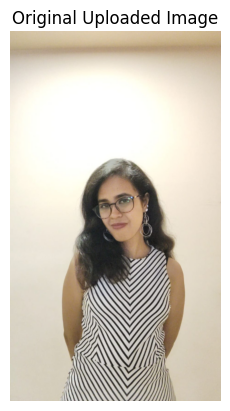

In [5]:
!pip install opencv-python-headless tensorflow matplotlib
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2, ResNet50
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import random
from google.colab import files
from PIL import Image
import io

uploaded = files.upload()

for filename in uploaded.keys():
    img = Image.open(io.BytesIO(uploaded[filename])).convert("RGB")
    img = np.array(img)
    break  # take only one image
plt.imshow(img)
plt.title("Original Uploaded Image")
plt.axis("off")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


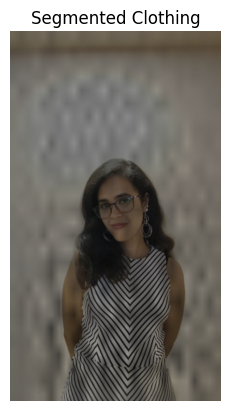

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Top Dominant Colors:
Color: [111, 108, 101] | 69.01%
Color: [60, 54, 44] | 22.56%
Color: [104, 104, 105] | 8.43%

Texture Feature Length: 16

Classification Prediction Vector: [[0.0653204396367073, 0.029962029308080673, 0.05295807868242264, 0.05971776694059372, 0.0828162431716919, 0.06331155449151993, 0.42892754077911377, 0.11483670771121979, 0.03942263498902321, 0.06272707134485245]]


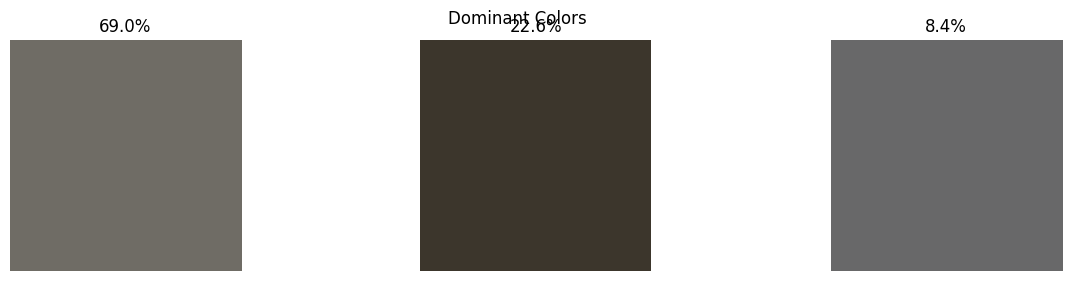

Top Matched Items:
1. Item 0
2. Item 4
3. Item 3
4. Item 1
5. Item 2


In [7]:
extractor = ClothingExtractor()
segmented = extractor.extract_clothing(img.astype('float32'))

plt.imshow(segmented.astype(np.uint8))
plt.title("Segmented Clothing")
plt.axis("off")
plt.show()
feature_extractor = ClothingFeatureExtractor()
features = feature_extractor.extract_features(segmented.astype(np.uint8))

# Show color feature summary
print("Top Dominant Colors:")
for c in features['colors']:
    print(f"Color: {c['color']} | {c['percentage']:.2f}%")

print("\nTexture Feature Length:", len(features['texture']))
print("\nClassification Prediction Vector:", features['classification'])
fig, ax = plt.subplots(1, len(features['colors']), figsize=(15, 3))
for i, c in enumerate(features['colors']):
    color = np.array(c['color'], dtype=np.uint8).reshape(1, 1, 3)
    ax[i].imshow(np.tile(color, (50, 50, 1)))
    ax[i].axis("off")
    ax[i].set_title(f"{c['percentage']:.1f}%")

plt.suptitle("Dominant Colors")
plt.show()
class DummyDB:
    def get_all_clothing_items(self):
        dummy_items = []
        for _ in range(5):
            dummy_items.append({
                'id': _,
                'name': f'Item {_}',
                'features': {
                    'classification': np.random.rand(10).tolist(),
                    'colors': random.sample(features['colors'], k=min(2, len(features['colors']))),
                    # Change the size of the texture features to 16 to match the query features
                    'texture': np.random.rand(16).tolist()
                }
            })
        return dummy_items

matcher = ClothingSimilarityMatcher(DummyDB())
similar_items = matcher.find_similar_items(features)

print("Top Matched Items:")
for i, item in enumerate(similar_items):
    print(f"{i+1}. {item['name']}")


In [10]:
!pip install rembg
!pip install onnxruntime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 66.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 6.1 MB/s eta 0:00:00


100%|███████████████████████████████████████| 176M/176M [00:00<00:00, 44.6GB/s]


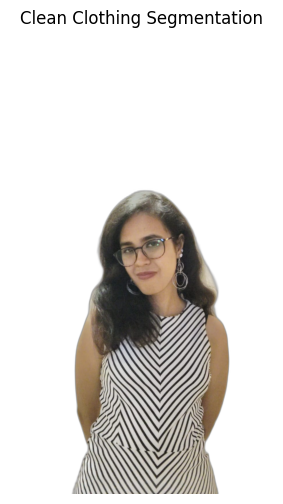

In [12]:
from rembg import remove
from PIL import Image
import io

# Instead of hardcoding the path, access the uploaded image using its filename
# Assuming 'uploaded' is the dictionary from the file upload cell
input_path = list(uploaded.keys())[0]  # Get the first uploaded filename

# Open the uploaded image using a byte stream
original = Image.open(io.BytesIO(uploaded[input_path])).convert("RGB")

# Remove background
output = remove(original)

# Show the result
plt.figure(figsize=(4,6))
plt.imshow(output)
plt.axis("off")
plt.title("Clean Clothing Segmentation")
plt.show()

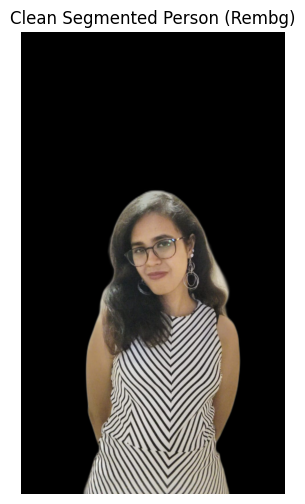

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


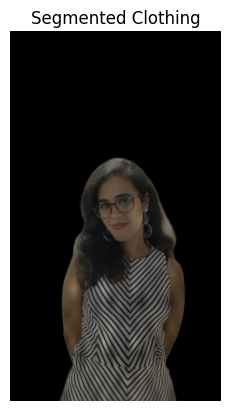

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Top Dominant Colors:
Color: [97, 95, 92] | 37.26%
Color: [30, 30, 26] | 36.60%
Color: [77, 62, 47] | 26.14%

Texture Feature Length: 16

Classification Prediction Vector: [[0.06998730450868607, 0.04871533066034317, 0.01229175180196762, 0.13503965735435486, 0.01303994283080101, 0.01938377134501934, 0.06904731690883636, 0.48532411456108093, 0.07115143537521362, 0.07601935416460037]]


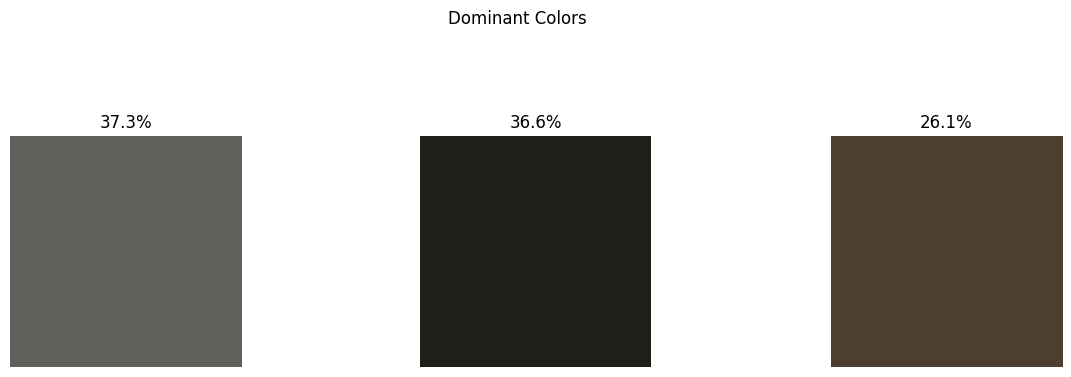


Top Matched Items:
1. Item 2
2. Item 1
3. Item 4
4. Item 0
5. Item 3


In [18]:
# Install rembg (only once)
!pip install rembg

# Imports
from rembg import remove
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import random
import io # Import io for working with in-memory files

# Load your uploaded image
# Access the uploaded image data directly from the 'uploaded' dictionary
input_image_data = uploaded[list(uploaded.keys())[0]]

# Open the image from the in-memory data using BytesIO
original = Image.open(io.BytesIO(input_image_data)).convert("RGB")

# Step 1: Remove Background (using rembg)
output = remove(original)
img_np = np.array(output)

# Convert the image from RGBA to RGB by dropping the alpha channel
img_np = img_np[:, :, :3] # Keep only the first 3 channels (RGB)

# Optional: show cleaned segmented person
plt.figure(figsize=(4,6))
plt.imshow(img_np)
plt.axis("off")
plt.title("Clean Segmented Person (Rembg)")
plt.show()

# Step 2: Use your existing pipeline from here
extractor = ClothingExtractor()
segmented = extractor.extract_clothing(img_np.astype('float32'))

# Step 3: Show segmented clothing
plt.imshow(segmented.astype(np.uint8))
plt.title("Segmented Clothing")
plt.axis("off")
plt.show()

# Step 4: Extract features (color, texture, classification)
feature_extractor = ClothingFeatureExtractor()
features = feature_extractor.extract_features(segmented.astype(np.uint8))

# Step 5: Print feature summary
print("Top Dominant Colors:")
for c in features['colors']:
    print(f"Color: {c['color']} | {c['percentage']:.2f}%")

print("\nTexture Feature Length:", len(features['texture']))
print("\nClassification Prediction Vector:", features['classification'])

# Step 6: Plot dominant colors
fig, ax = plt.subplots(1, len(features['colors']), figsize=(15, 3))
for i, c in enumerate(features['colors']):
    color = np.array(c['color'], dtype=np.uint8).reshape(1, 1, 3)
    ax[i].imshow(np.tile(color, (50, 50, 1)))
    ax[i].axis("off")
    ax[i].set_title(f"{c['percentage']:.1f}%")
plt.suptitle("Dominant Colors", y=1.3)
plt.show()

# Step 7: Create dummy DB and run similarity matching
class DummyDB:
    def get_all_clothing_items(self):
        dummy_items = []
        for _ in range(5):
            dummy_items.append({
                'id': _,
                'name': f'Item {_}',
                'features': {
                    'classification': np.random.rand(10).tolist(),
                    'colors': random.sample(features['colors'], k=min(2, len(features['colors']))),
                    'texture': np.random.rand(16).tolist()
                }
            })
        return dummy_items

matcher = ClothingSimilarityMatcher(DummyDB())
similar_items = matcher.find_similar_items(features)

# Step 8: Print similar items
print("\nTop Matched Items:")
for i, item in enumerate(similar_items):
    print(f"{i+1}. {item['name']}")